In [1]:
library('caret')

Loading required package: lattice
Loading required package: ggplot2


In [2]:
library(data.table)
library(ggplot2)
library(plyr)
library(dplyr)
library(corrplot)
library(pROC)
library(glmnet)
library(caret)
library(Rtsne)
library(xgboost)
library(doMC)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:data.table':

    between, first, last

The following object is masked from 'package:Biobase':

    combine

The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

corrplot 0.84 loaded
Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following object is masked from 'package:BiocGenerics':

    var

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: 'glmnet'

The following object is masked from 'package:pROC'

In [3]:
data <- read.csv("creditcard.csv")


In [4]:
data$Class <- as.character(data$Class)
summary(data)

      Time              V1                  V2                  V3          
 Min.   :     0   Min.   :-56.40751   Min.   :-72.71573   Min.   :-48.3256  
 1st Qu.: 54202   1st Qu.: -0.92037   1st Qu.: -0.59855   1st Qu.: -0.8904  
 Median : 84692   Median :  0.01811   Median :  0.06549   Median :  0.1799  
 Mean   : 94814   Mean   :  0.00000   Mean   :  0.00000   Mean   :  0.0000  
 3rd Qu.:139321   3rd Qu.:  1.31564   3rd Qu.:  0.80372   3rd Qu.:  1.0272  
 Max.   :172792   Max.   :  2.45493   Max.   : 22.05773   Max.   :  9.3826  
       V4                 V5                   V6                 V7          
 Min.   :-5.68317   Min.   :-113.74331   Min.   :-26.1605   Min.   :-43.5572  
 1st Qu.:-0.84864   1st Qu.:  -0.69160   1st Qu.: -0.7683   1st Qu.: -0.5541  
 Median :-0.01985   Median :  -0.05434   Median : -0.2742   Median :  0.0401  
 Mean   : 0.00000   Mean   :   0.00000   Mean   :  0.0000   Mean   :  0.0000  
 3rd Qu.: 0.74334   3rd Qu.:   0.61193   3rd Qu.:  0.3986   3rd Qu

In [5]:
common_theme <- theme(plot.title = element_text(hjust = 0.5, face = "bold"))
data %>% group_by(Class) %>% summarise(mean(Amount), median(Amount))

Class,mean(Amount),median(Amount)
0,88.29102,22.00
1,122.21132,9.25


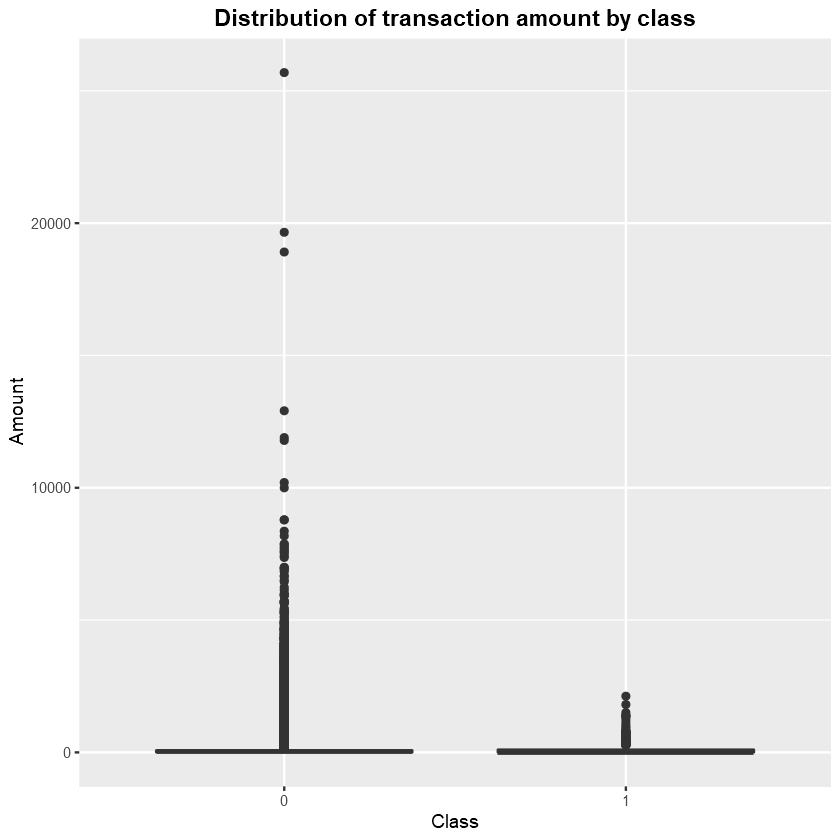

In [6]:

p <- ggplot(data, aes(x = Class, y = Amount)) + geom_boxplot() + ggtitle("Distribution of transaction amount by class") + common_theme
print(p)

In [7]:
#Checking NULL vaules and replacing them if any.
sum(is.na(data))
apply(apply(data,2,is.na),2,sum) 



[1] 0

Time     V1     V2     V3     V4     V5     V6     V7     V8     V9    V10 
     0      0      0      0      0      0      0      0      0      0      0 
   V11    V12    V13    V14    V15    V16    V17    V18    V19    V20    V21 
     0      0      0      0      0      0      0      0      0      0      0 
   V22    V23    V24    V25    V26    V27    V28 Amount  Class 
     0      0      0      0      0      0      0      0      0

In [9]:
library(lubridate)


Attaching package: 'lubridate'

The following object is masked from 'package:plyr':

    here

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from 'package:base':

    date



In [10]:
#Convert time elapsed from int to duration object using lubridate.
str(data[ , 1])
data$duration<-sapply(data[ , 1], as.numeric)
class(data$duration)
str(data$duration)
data$duration<-duration(data$duration)
class(data$duration)
str(data$duration)
data$Time<-NULL

 num [1:284807] 0 0 1 1 2 2 4 7 7 9 ...


[1] "numeric"

 num [1:284807] 0 0 1 1 2 2 4 7 7 9 ...


[1] "Duration"
attr(,"package")
[1] "lubridate"

Formal class 'Duration' [package "lubridate"] with 1 slot
  ..@ .Data: num [1:284807] 0 0 1 1 2 2 4 7 7 9 ...


In [11]:
#Convert the class column from numeric to factor.
data$classification<-sapply(data[, 30], as.numeric)
data$classification<-as.factor(data$classification)
data$Class<-NULL
levels(data$classification)

[1] "0" "1"

In [12]:
#Scaling, centering and boxcox transformation.

data_trans<-preProcess(data[,c(-30,-31)],  method=c("BoxCox", "center", "scale"))
data_norm<-predict(data_trans, data[,c(-30,-31)])
dim(data_norm)
class(data_norm)
data_norm <- cbind(data_norm,data[ , c(30,31)])

[1] 284807     29

[1] "data.frame"

In [ ]:

normalize <- function(x){
  return((x - mean(x, na.rm = TRUE))/sd(x, na.rm = TRUE))
}
data$Amount <- normalize(data$Amount)